In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Activation, TimeDistributed
from keras.optimizers import Adam, SGD, RMSprop

C:\Users\ktsyganov\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Данные

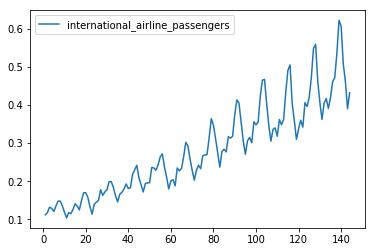

In [2]:
df = pd.read_csv('data/international-airline-passengers.csv', index_col=0)
df.index = range(1, len(df)+1)
df /= 1000
df.plot()

# Задача - построить прогнозную модель временного ряда

### Преобразование данных для работы с нейронной сетью

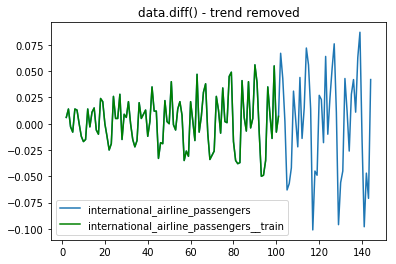

In [3]:
data = df.diff()  # remove trend
data = data.iloc[1:]
train_test_split_index = 100
data_train = data[:train_test_split_index]

fig, ax = plt.subplots()
data.plot(ax=ax, title='data.diff() - trend removed')
data_train.rename(columns={c:'{}__train'.format(c) for c in data_train.columns}).plot(ax=ax, color='g')

### Определим рекуррентную сеть

Наша сеть будет предсказывать следующее значение ряда. Поставим задачу так, что на вход приходит последовательность, на выходе будет последовательность той же длины, только смещенная вправо на один элемент - таким образом, последний элемент выхода будет прогнозом на одну точку вперед.

**Пример**

Вход: [1, 2, 3, 4]

Выход: [2, 3, 4, 5]

In [14]:
model = Sequential()
# input_shape = (time_steps, input_dim) - where input_dim is the number of features X
model.add(SimpleRNN(units=10, input_shape=(None, data.shape[1]), return_sequences=True, activation='tanh'))
model.add(TimeDistributed(Dense(data.shape[1])))
model.add(Activation('linear'))
model.compile(loss='mse', optimizer='rmsprop')

Преобразуем данные к формату для подачи в сеть

In [15]:
X_ = data_train.iloc[:-1]
y_ = data_train.iloc[1:]

X = X_.values.reshape(1, *X_.shape)
y = y_.values.reshape(1, *y_.shape)

In [16]:
X.shape

(1, 99, 1)

In [17]:
history = model.fit(X, y, epochs=100, verbose=0)

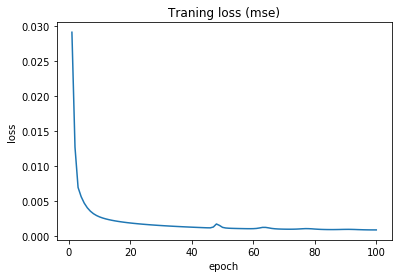

In [18]:
# PLOT LOSS
fig, ax = plt.subplots()
ax.plot(range(1, len(history.history['loss'])+1), history.history['loss'])
plt.xlabel('epoch'), ax.set_ylabel('loss'), plt.title('Traning loss (mse)')
plt.show()

### Как запускать прогноз

In [9]:
input_seq = X[0][:2]
output_seq = model.predict(np.array([input_seq]))[0]

print('Input sample: \n{}\n'.format(input_seq))
print('Output: \n{}'.format(output_seq))

Input sample: 
[[0.006]
 [0.014]]

Output: 
[[0.00632539]
 [0.00203975]]


### Построение рекуррентного прогноза

In [10]:
# forecast_horizon = 10
forecast_horizon = data.index[-1] - X_.index[-1]

sample_len = X_.shape[0]
forecast = X_.values
for i in range(forecast_horizon):
    x_sample = forecast
    forecast1_ = model.predict(x_sample.reshape(1, *x_sample.shape))
    forecast1 = forecast1_[0][[-1]]
    forecast1 = forecast1
    # print('forecast1', forecast1)
    forecast = np.append(forecast, forecast1, axis=0)
y_pred = pd.DataFrame(data=forecast[sample_len:], columns=X_.columns)
y_pred.index = data.loc[X_.index[-1]+1: X_.index[-1]+1+forecast_horizon].index

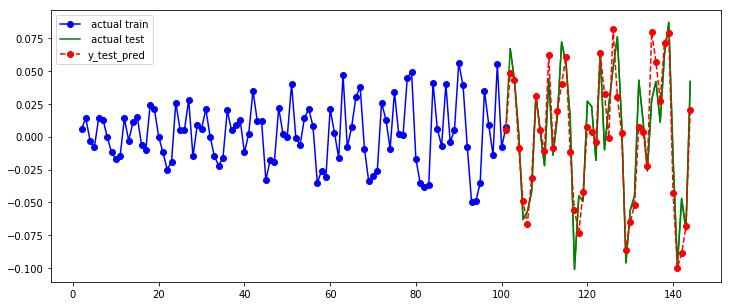

In [11]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(data_train.index, data_train, 'b-o', label=' actual train')
ax.plot(data.iloc[len(data_train):].index, data.iloc[len(data_train):], 'g-', label=' actual test')
ax.plot(data.iloc[len(data_train)-1:].index, data.iloc[len(data_train)-1:], 'g-')
ax.plot(y_pred.index, y_pred, 'r--o', label='y_test_pred')
ax.legend(loc='best')

Мы предсказывали **изменения** исходного ряда. Для получения прогноза исходного ряда в момент времени $t$ необходимо к первой точке исходного ряда добавить сумму всех изменений к моменту $t$.

In [12]:
df_forecast = df.loc[[data_train.index[-1]-1]]
for i in range(y_pred.shape[0]):
    row = pd.DataFrame(
        data=y_pred.iloc[[i]].values + df_forecast.iloc[[i]].values,
        columns=df_forecast.columns, index=y_pred.iloc[[i]].index)
    df_forecast = df_forecast.append(row)

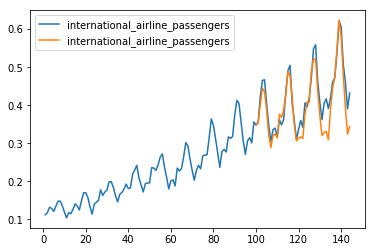

In [13]:
fig, ax = plt.subplots()

df.plot(ax=ax)
df_forecast.plot(ax=ax)

In [ ]:
input_seq = X[0][:2]
output_seq = model.predict(np.array([input_seq]))[0]